In [1]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import cross_validation
from sklearn import tree as Tree
from sklearn import ensemble
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
import sklearn.tree
%matplotlib inline 

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load in trial data and convert into switches

### (Drop current trial duration)

In [8]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/80_20_processed_data/new_master_8020_df.csv',index_col=0)
data = data.drop('0_trialDuration',axis=1)

switches = np.abs(np.diff(data['Decision'].values))
data = data.iloc[1:,:]
data['Decision'] = switches
feature_names = data.columns.values[:-1]
data.head(4)

,Previous_10_Left_Choice,Previous_10_Right_Choice,Previous_10_Left_Reward,Previous_10_Right_Reward,Streak,5_Port,5_Reward,5_ITI,5_trialDuration,4_Port,...,2_Port,2_Reward,2_ITI,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision
1,10.0,0.0,7.0,0.0,-2.0,1.0,1.0,2.405,0.463,1.0,...,1.0,0.0,2.133,0.482,1.0,0.0,1.411,0.435,2.169,1.0
2,9.0,1.0,6.0,0.0,-3.0,1.0,1.0,2.379,0.367,1.0,...,1.0,0.0,1.411,0.435,0.0,0.0,2.169,0.395,3.838,0.0
3,8.0,2.0,5.0,0.0,-4.0,1.0,1.0,2.234,0.325,1.0,...,0.0,0.0,2.169,0.395,0.0,0.0,3.838,0.469,1.846,1.0
4,8.0,2.0,5.0,0.0,1.0,1.0,0.0,2.133,0.482,1.0,...,0.0,0.0,3.838,0.469,1.0,1.0,1.846,0.378,1.527,0.0


In [3]:
#extract features and decisions
x = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [4]:
#split into training and testing
n_trials = x.shape[0]
shuf_inds = np.random.permutation(n_trials)
split_ind = int(n_trials*0.7)

x_train = x[shuf_inds[:split_ind],:]
y_train = y[shuf_inds[:split_ind]]

x_test = x[shuf_inds[split_ind:],:]
y_test = y[shuf_inds[split_ind:]]

# Logistic Regression

In [15]:
'''
Logistic Regression
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    logreg = sklearn.linear_model.LogisticRegressionCV(class_weight = {0:1.0-p,1:p})
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        logreg.fit(x_train_cv,y_train_cv)
        y_predict = logreg.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

In [20]:
balanced_weight = 1.0 - np.sum(y_train).astype('float') / y_train.shape[0]

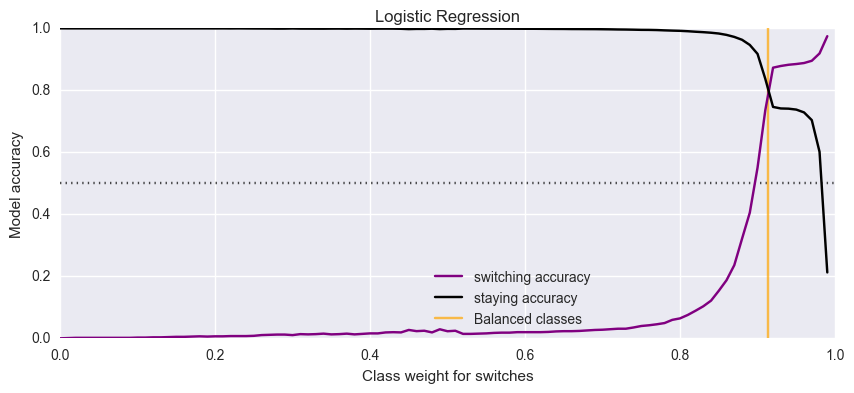

In [23]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.vlines(x=balanced_weight,ymin=0,ymax=1,alpha=0.7,color='orange',label='Balanced classes')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Class weight for switches')
plt.ylabel('Model accuracy')
plt.title('Logistic Regression')

In [122]:
logreg = sklearn.linear_model.LogisticRegressionCV(Cs=10,penalty='l2',class_weight='balanced')
logreg.fit(x_train,y_train)
y_predict_logreg = logreg.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_logreg,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         4406.0         1319.0
True YES          83.0          442.0

F1: 0.387

Accuracy on class 0: 0.77
Accuracy on class 1: 0.84



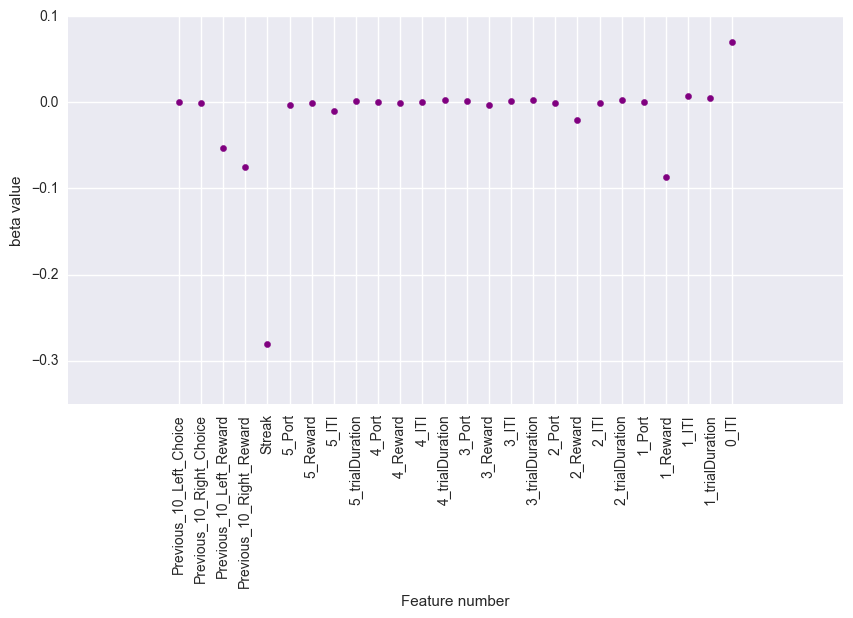

In [25]:
coefs = logreg.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

# LDA

In [11]:
'''
LDA
'''
P = np.arange(0,1,0.01)

acc_cv = []

for i,p in enumerate(P):
    prior = np.array([1.0-p,p])
    lda = discriminant_analysis.LinearDiscriminantAnalysis(priors = prior)
    
    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0
    
    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        lda.fit(x_train_cv,y_train_cv)
        y_predict = lda.predict(x_test_cv)
        
        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)
        
        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:401: RuntimeWarning: invalid value encountered in true_divide
  S**2))[:self._max_components]
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:406: RuntimeWarning: divide by zero encountered in log
  np.log(self.priors_))


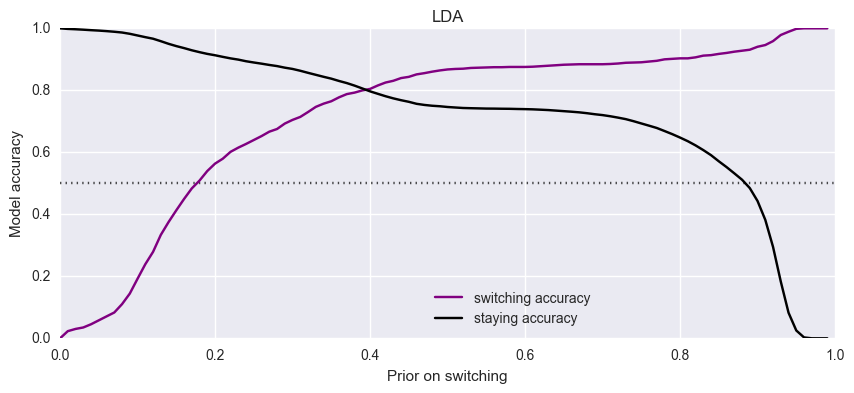

In [12]:
plt.figure(figsize=(10,4))
plt.plot(P,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(P,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=1,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(0,1)
plt.xlabel('Prior on switching')
plt.ylabel('Model accuracy')
plt.title('LDA')

In [123]:
lda = discriminant_analysis.LinearDiscriminantAnalysis(priors=[0.6,0.4])
lda.fit(x_train,y_train)
y_predict_lda = lda.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_lda,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         4572.0         1153.0
True YES          97.0          428.0

F1: 0.406

Accuracy on class 0: 0.80
Accuracy on class 1: 0.82



/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


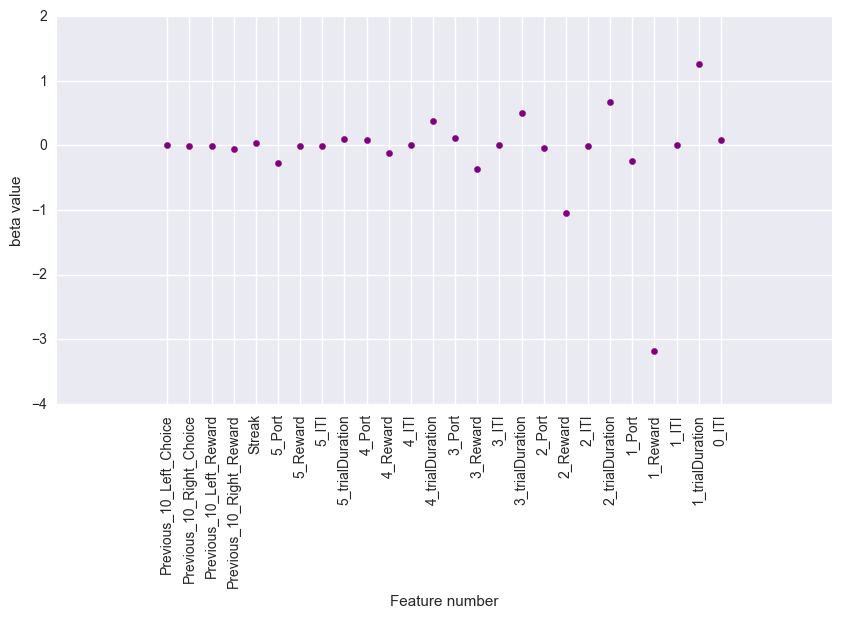

In [14]:
coefs = best_lda.coef_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),coefs[0],color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('beta value')
plt.xlabel('Feature number')

# Decision Tree

In [45]:
D = np.arange(1,17)

acc_cv = []

for i,d in enumerate(D):
    tree = Tree.DecisionTreeClassifier(max_depth=d,class_weight='balanced')

    kf = cross_validation.KFold(x_train.shape[0],n_folds=3)
    cum_acc_pos = 0
    cum_acc_neg = 0

    for train_index,test_index in kf:
        x_train_cv = x_train[train_index,:]
        y_train_cv = y_train[train_index]
        x_test_cv = x_train[test_index,:]
        y_test_cv = y_train[test_index]

        tree.fit(x_train_cv,y_train_cv)
        y_predict = tree.predict(x_test_cv)

        acc_pos,acc_neg,F1 = sf.score_both_and_confuse(y_predict,y_test_cv,confusion=False,disp=False)

        cum_acc_pos += acc_pos
        cum_acc_neg += acc_neg

    acc_cv.append([cum_acc_pos / 3.0,cum_acc_neg / 3.0])

acc_cv = np.asarray(acc_cv)

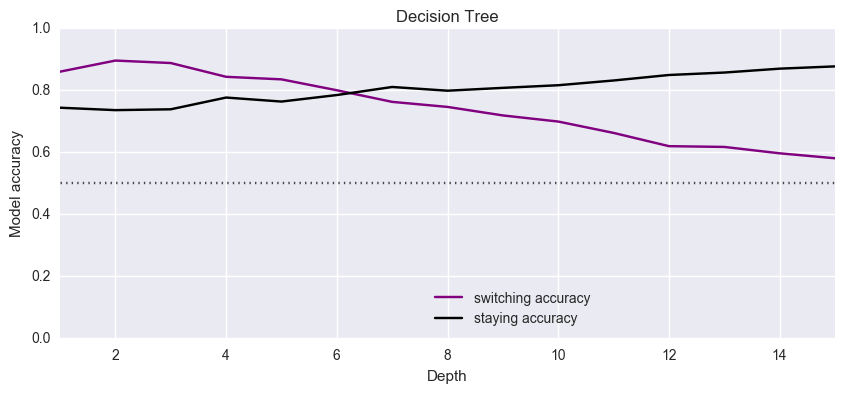

In [47]:
plt.figure(figsize=(10,4))
plt.plot(D,acc_cv[:,0],color='purple',label='switching accuracy')
plt.plot(D,acc_cv[:,1],color='black',label='staying accuracy')
plt.hlines(y=0.5,xmin=0,xmax=15,color='black',alpha=0.7,linestyle='dotted')
plt.legend(loc='lower right',bbox_to_anchor=[0.7,0])
plt.xlim(1,15)
plt.ylim(0,1)
plt.xlabel('Depth')
plt.ylabel('Model accuracy')
plt.title('Decision Tree')

In [124]:
tree = Tree.DecisionTreeClassifier(max_depth = 4,class_weight='balanced')
tree.fit(x_train,y_train)
y_predict_tree = tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_tree,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         4268.0         1457.0
True YES          72.0          453.0

F1: 0.372

Accuracy on class 0: 0.75
Accuracy on class 1: 0.86



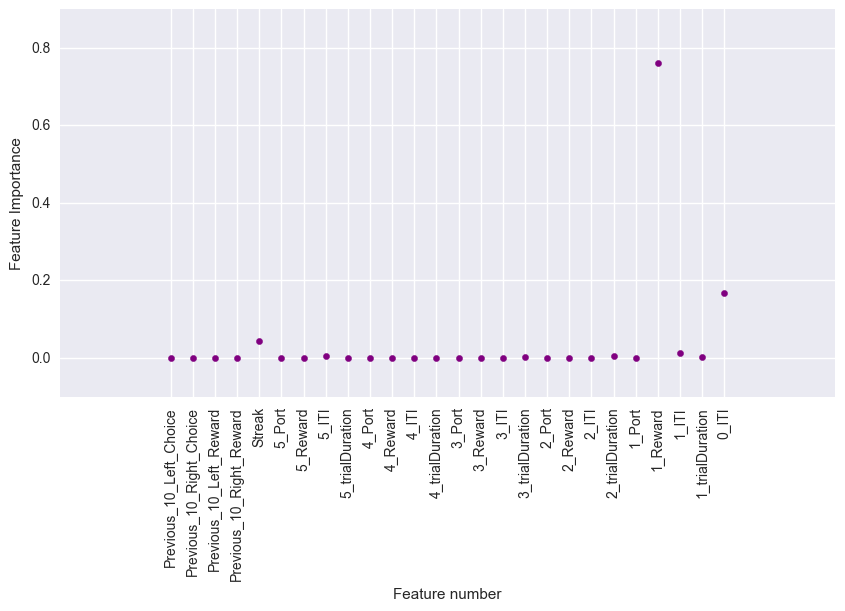

In [125]:
tree_f_impt = tree.feature_importances_
plt.figure(figsize=(10,5))
plt.scatter(np.arange(coefs[0].shape[0]),tree_f_impt,color='purple')
plt.xticks(np.arange(coefs[0].shape[0]),feature_names,rotation='vertical')
plt.ylabel('Feature Importance')
plt.xlabel('Feature number')

# Weights idea
assign weights propto negative streak value. IE the more you've gotten wrong in a row, the more likely you should be to switch. Actually - let's see if that's true first

In [61]:
streaks = np.unique(data['Streak'].values)
p_switch = np.zeros_like(streaks)

for i,s in enumerate(streaks):
    p_switch[i] = np.sum(data[data['Streak']== s]['Decision'].values).astype('float') / data[data['Streak']== s].shape[0]

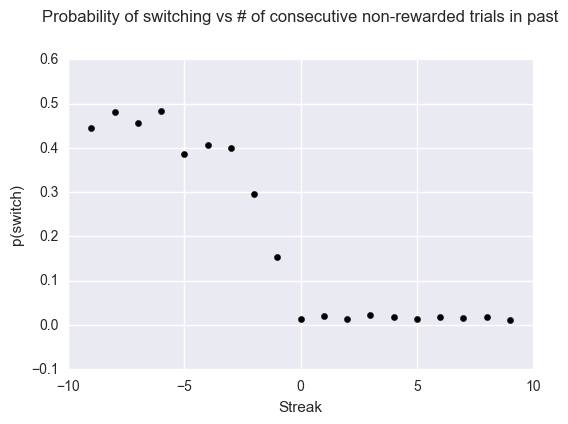

In [65]:
plt.scatter(streaks,p_switch,color='black')
plt.title('Probability of switching vs # of consecutive non-rewarded trials in past',x=0.5,y=1.1)
plt.ylabel('p(switch)')
plt.xlabel('Streak')

In [128]:
streaks = np.unique(data['Streak'].values)
p_switch_true = np.zeros_like(streaks)
p_switch_logreg = np.zeros_like(streaks)
p_switch_lda = np.zeros_like(streaks)
p_switch_tree = np.zeros_like(streaks)

for i,s in enumerate(streaks):
    p_switch_true[i] = np.sum(data[data['Streak']== s]['Decision'].values).astype('float') / data[data['Streak']== s].shape[0]
    p_switch_logreg[i] = np.sum(y_predict_logreg[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)
    p_switch_lda[i] = np.sum(y_predict_lda[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)
    p_switch_tree[i] = np.sum(y_predict_tree[x_test[:,4] == s]).astype('float') / np.sum(x_test[:,4] == s)

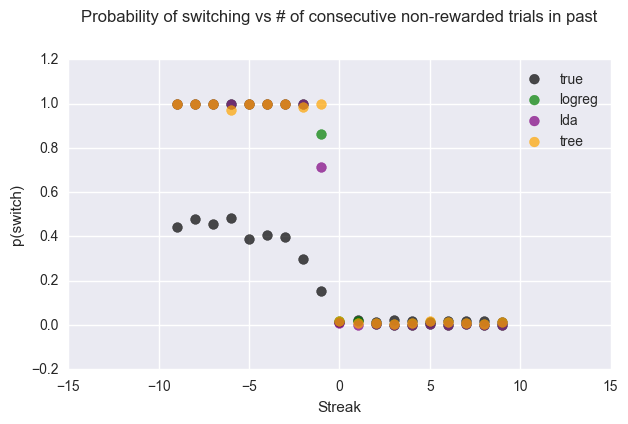

In [137]:
plt.figure(figsize=(7,4))
plt.scatter(streaks,p_switch_true,color='black',label='true',s=50,alpha=0.7)
plt.scatter(streaks,p_switch_logreg,color='green',label = 'logreg',alpha=0.7,s=50)
plt.scatter(streaks,p_switch_lda,color='purple',label='lda',alpha=0.7,s=50)
plt.scatter(streaks,p_switch_tree,color='orange',label='tree',alpha=0.7,s=50)
plt.legend(loc='best')
plt.title('Probability of switching vs # of consecutive non-rewarded trials in past',x=0.5,y=1.1)
plt.ylabel('p(switch)')
plt.xlabel('Streak')

Should compare this graph with 90-10, 70-30 conditions.

This is where all of the false positives are coming!

# Try weighting training samples more if they have a negative streak value

In [116]:
sample_weights = np.zeros_like(y_train) + 0.1
sample_weights[x_train[:,4] < -2] = 10

### Decision Tree

In [117]:
weighted_tree = Tree.DecisionTreeClassifier(max_depth = 4,class_weight='balanced')
weighted_tree.fit(x_train,y_train,sample_weight=sample_weights)
y_predict = weighted_tree.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,disp=True,confusion=False)

          Predicted NO  Predicted YES
True NO         4333.0         1392.0
True YES          85.0          440.0

F1: 0.373

Accuracy on class 0: 0.76
Accuracy on class 1: 0.84



### Logistic Regression

In [118]:
weighted_logreg = sklearn.linear_model.LogisticRegressionCV(Cs=10,penalty='l2',class_weight='balanced')
weighted_logreg.fit(x_train,y_train,sample_weight=sample_weights)
y_predict = weighted_logreg.predict(x_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict,y_test,confusion=False)

          Predicted NO  Predicted YES
True NO         4290.0         1435.0
True YES          80.0          445.0

F1: 0.370

Accuracy on class 0: 0.75
Accuracy on class 1: 0.85



Well that doesn't seem to do much. 